In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [18]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
station = '080'
data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

# Obtain dataset
df = spark.read.parquet(data_files) \
        .withColumn("precipitation", col("precipitation").cast("float")) \
        .select("date","precipitation") \
        .toPandas()

In [19]:
# Set the date column as the index and ensure it's a DatetimeIndex
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,precipitation
date,
1943-04-02,0.0
1943-04-03,0.0
1943-04-04,0.0
1943-04-05,0.0
1943-04-06,0.0


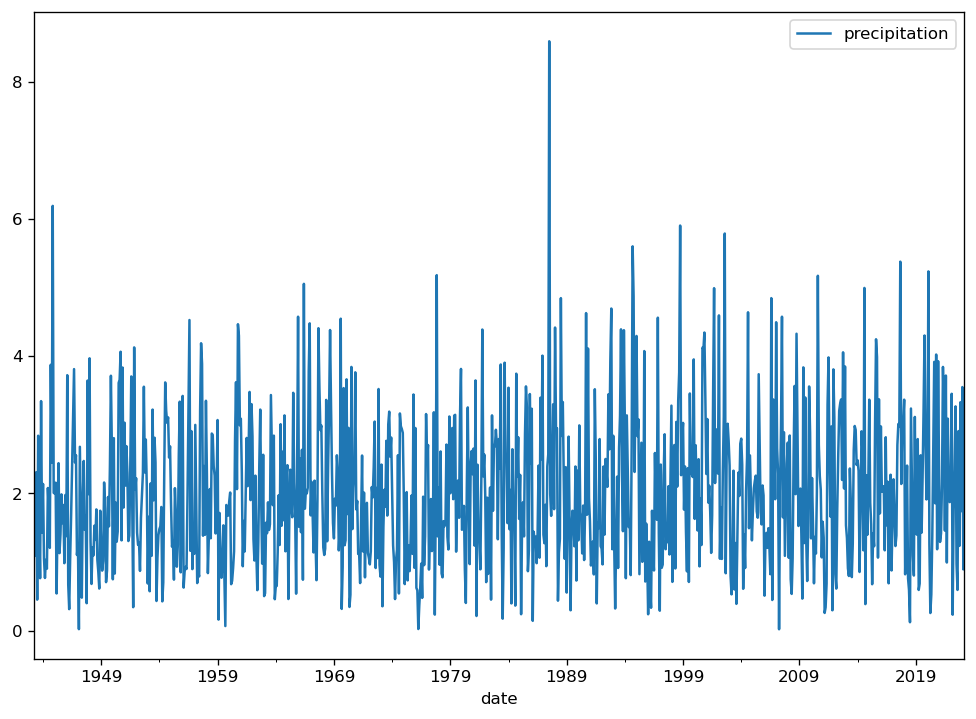

In [20]:
df.resample("M").mean().plot()

# Stationary Test

In [21]:
#%pip install arch

In [22]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)


# SARIMA

In [23]:
def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    output = df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]
    print(f"Records removed: {df.shape[0] - output.shape[0]}")
    return output


## Stationary test

In [24]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)


#Montly Data
# remove outliers
df_seasson = remove_outlier(df.resample('1M').mean())
test_stationarity(df_seasson.precipitation)

Records removed: 12
ADF Test:
Test statistic: -5.940071336856146
null_hypothesis: the time series is non-stationary
P-value: 2.2719955774959303e-07
Critical values:
1%: -3.437439232284603
5%: -2.8646696476686477
10%: -2.5684364181154127
STATIONARY

KPSS Test:
null_hypothesis: the time series is trend stationary
Test statistic: 0.030637368629462605
P-value: 0.1
Critical values:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216
STATIONARY


/anaconda/envs/py38_default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## SARIMA

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

scaler = MinMaxScaler()
df_seasson = scaler.fit_transform(df_seasson)

train_data, test_data = train_test_split(df_seasson, test_size=0.2,shuffle=False)


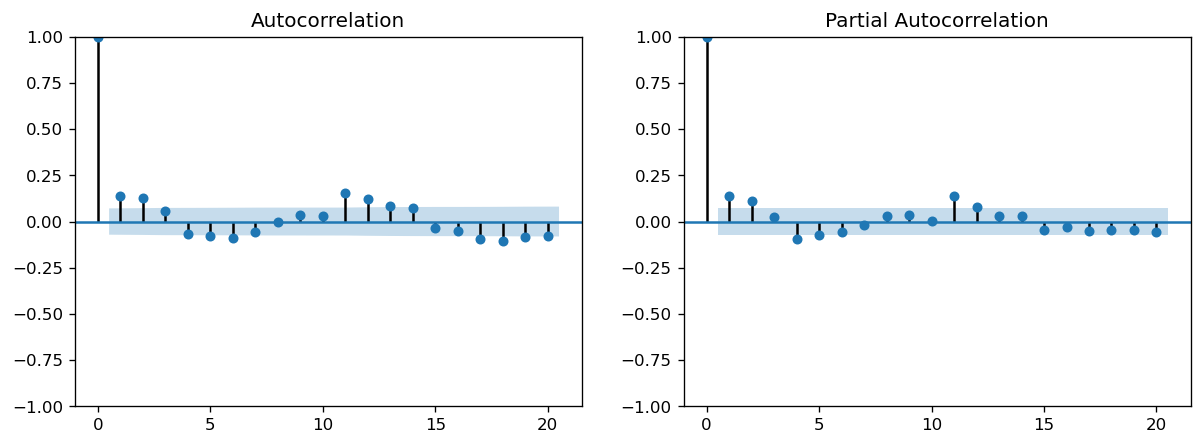

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_data, lags=20, ax=ax1)
plot_pacf(train_data, lags=20, ax=ax2)
plt.show()


In [27]:
p = 1
d = 0
q = 1
s = 12  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)
P = 1
D = 1
Q = 1

model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.26694D-02    |proj g|=  1.45244D+00

At iterate    5    f= -1.26515D-01    |proj g|=  3.30505D-01

At iterate   10    f= -1.43825D-01    |proj g|=  3.99335D-01

At iterate   15    f= -1.51237D-01    |proj g|=  4.39659D-02

At iterate   20    f= -1.53113D-01    |proj g|=  3.73534D-02

At iterate   25    f= -1.53175D-01    |proj g|=  1.31512D-02

At iterate   30    f= -1.53964D-01    |proj g|=  1.78754D-02

At iterate   35    f= -1.54238D-01    |proj g|=  7.34466D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [ ]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

# Calculate evaluation metrics
test_rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
test_mae = mean_absolute_error(test_data, mean_predictions)
#test_mape = np.mean(np.abs((test_data - mean_predictions) / test_data)) * 100
#test_mase = test_mae / (np.mean(np.abs(test_data[1:] - test_data[:-1])))

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
#print(f"Test MAPE: {test_mape:.2f}%")
#print(f"Test MASE: {test_mase:.2f}")



In [ ]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()


## AUTO ARIMA

In [17]:
#%pip install pmdarima

In [ ]:
import pmdarima as pm

scaler = MinMaxScaler()
df_seasson = df.resample('M').mean()
df_seasson = scaler.fit_transform(df_seasson)

train_data, test_data = train_test_split(df_seasson, test_size=0.2,shuffle=False)
train_data, test_data = train_test_split(df_seasson, test_size=0.2,shuffle=False)

auto_model = pm.auto_arima(train_data,
                      seasonal=True,
                      m=12,  # Seasonal frequency
                      start_p=0, start_q=0, max_p=3, max_q=3,  # Non-seasonal parameters
                      start_P=0, start_Q=0, max_P=3, max_Q=3,  # Seasonal parameters
                      d=None, D=None,  # Orders of differencing
                      trace=True,  # Print search information
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)  # Stepwise search for efficiency



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-566.676, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-778.029, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-568.675, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-774.478, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-776.481, Time=0.99 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-777.769, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.24 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-565.890, Time=0.23 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-833.721, Time=0.72 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-828.078, Time=0.19 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-834.502, Time=2.26 sec
 ARIMA(2,1,0)(3,0,0)[12] intercept   : AIC=-836.439, Time=3.86 sec
 ARIMA(2,1,0)(3,0,1)[12] intercept

In [13]:
print(f"Best SARIMA Model: {auto_model.order}, {auto_model.seasonal_order}")

Best SARIMA Model: (3, 1, 0), (3, 0, 1, 12)


In [14]:
model = SARIMAX(train_data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.58017D-01    |proj g|=  1.25241D-01

At iterate    5    f= -5.67901D-01    |proj g|=  3.29160D-02

At iterate   10    f= -5.69018D-01    |proj g|=  4.42811D-02

At iterate   15    f= -5.69050D-01    |proj g|=  3.69772D-02

At iterate   20    f= -5.70488D-01    |proj g|=  5.02868D-02

At iterate   25    f= -5.79773D-01    |proj g|=  2.45025D-01

At iterate   30    f= -5.84780D-01    |proj g|=  1.94376D-02

At iterate   35    f= -5.88954D-01    |proj g|=  3.42860D-02

At iterate   40    f= -5.91834D-01    |proj g|=  1.66247D-02

At iterate   45    f= -5.93118D-01    |proj g|=  1.16654D-02

At iterate   50    f= -5.93381D-01    |proj g|=  9.79982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/anaconda/envs/py38_default/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
print(f"RMSE: {rmse}")


RMSE: 0.1779368245347726


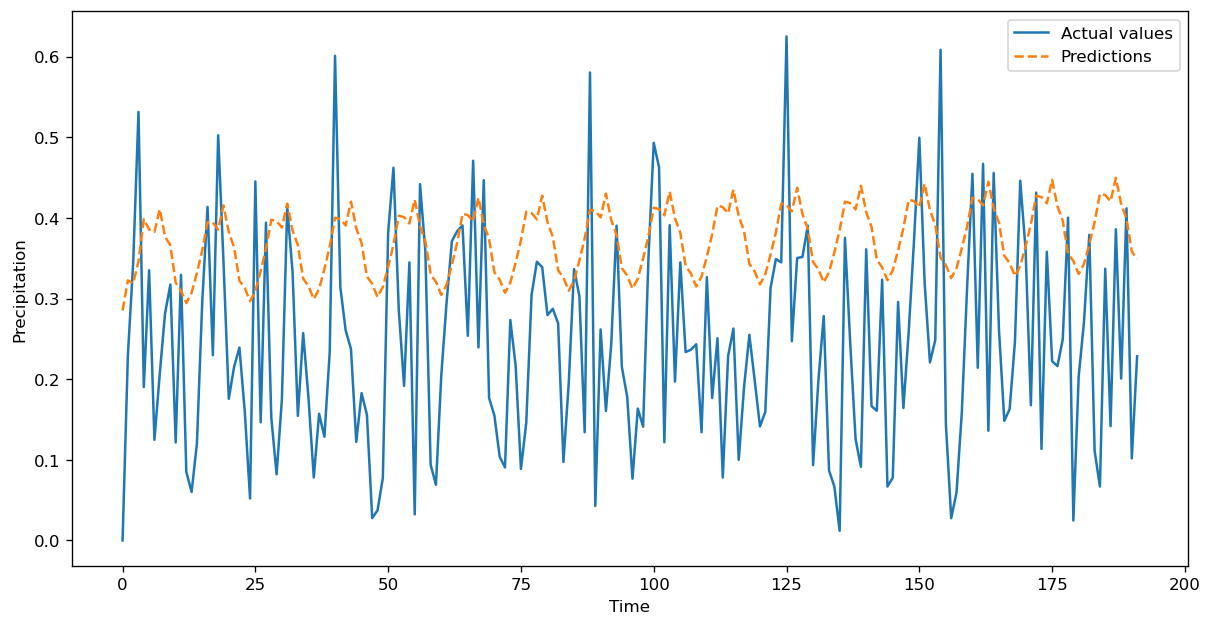

In [16]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()